## Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
from skimage import io, color, feature, data, filters, util, color, transform, exposure, measure
from sklearn import preprocessing
# permite dividir o conjunto de dados en treino e teste
from sklearn.model_selection import train_test_split
from sklearn import metrics, datasets
from sklearn import svm
from scipy import ndimage
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Leitura da bas MNIST em formato csv

<p>A base de dados MNIST (base de dados do Instituto Nacional Modificado de Padrões e Tecnologia) é uma coleção amplamente utilizada de dígitos manuscritos, comumente empregada para treinar e testar sistemas de processamento de imagens e modelos de aprendizado de máquina.</p>

<img src="https://datasets.activeloop.ai/wp-content/uploads/2019/12/MNIST-handwritten-digits-dataset-visualized-by-Activeloop.webp" />

<p>
O conjunto de dados original está em um formato que pode ser desafiador para iniciantes. Este dataset, criado com o trabalho de Joseph Redmon, fornece a base MNIST em formato CSV, disponível no <a href="https://www.kaggle.com/datasets/oddrationale/mnist-in-csv">Kaggle</a></p>

<p>
O conjunto de dados está dividido em dois arquivos:
 <ol>
 <li>mnist_train.csv</li>
 <li>mnist_test.csv</li>
 </ol>
<p>

<p>
O arquivo <i>mnist_train.csv</i> contém 60.000 exemplos de treinamento, enquanto o <i>mnist_test.csv</i> contém 10.000 exemplos de teste. Cada linha desses arquivos é composta por 785 valores: o primeiro valor é o rótulo (um número de 0 a 9) e os 784 valores restantes correspondem aos valores de pixel (números entre 0 e 255). A imagem bidimensional de $28 \times 28$ pixels é reorganizada em um vetor unidimensional de $1 \times 784$, onde cada linha da matriz representa uma imagem distinta.</p>


In [2]:
# download do treino
!gdown 1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb

Downloading...
From (original): https://drive.google.com/uc?id=1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb
From (redirected): https://drive.google.com/uc?id=1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb&confirm=t&uuid=b64a6945-19b6-49a4-876f-c9ee432f741d
To: /content/mnist_train.csv
100% 110M/110M [00:04<00:00, 22.8MB/s]


In [3]:
# download do teste
!gdown 1v8m7yCg0GrJBzWs2MVUPs_Ywe3dTvbCx

Downloading...
From: https://drive.google.com/uc?id=1v8m7yCg0GrJBzWs2MVUPs_Ywe3dTvbCx
To: /content/mnist_test.csv
100% 18.3M/18.3M [00:00<00:00, 20.3MB/s]


## Carregar os arquivos com o conjunto de treino e teste

In [4]:
data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')

### Separação das imagens de seus respectivos rótulos e transformação dos dados para o formato Numpy

In [5]:
# imagens
x_tmp_train = data_train.iloc[:,1:].to_numpy()
# etiquetas
y_tmp_train = data_train.iloc[:,0].to_numpy()

# imagen
x_img_test = data_test.iloc[:,1:].to_numpy()
# etiquetas
y_img_test = data_test.iloc[:,0].to_numpy()

<p> Divida o conjunto de treino em dois subconjuntos: treino e validação. Em seguida, instancie um classificador SVM e treine-o com o subconjunto de treino. Valide o desempenho dos hiperparâmetros escolhidos utilizando o subconjunto de validação. Por fim, avalie o modelo utilizando o conjunto de teste. Gere a matriz de confusão tanto para a validação quanto para o teste.</p>

In [6]:
x_img_train, x_img_val, y_train, y_val = train_test_split(x_tmp_train, y_tmp_train, test_size=0.2, random_state=42)

## Histograma de Gradientes Orientados (HoG)
<p>
O Histograma de Gradientes Orientados, conhecido como HOG, é um descritor de características semelhante ao SIFT (<i>Scale Invariant Feature Transform</i>). Ele é amplamente utilizado em visão computacional e processamento de imagens para detecção de objetos. A técnica consiste em contar as ocorrências das orientações dos gradientes em regiões específicas de uma imagem. O descritor HOG foca na estrutura ou forma de um objeto, sendo mais eficaz do que descritores de borda, pois utiliza tanto a magnitude quanto o ângulo do gradiente para calcular as características. Em diferentes regiões da imagem, o HOG gera histogramas baseados na magnitude e nas orientações dos gradientes.</p>

<p>
<b>feature.hog</b>(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block ch_norm='L2-Hys', channel_axis=None)

Parâmetros:
<ul>
 <li>image: imagem</li>
 <li>orientations: número de orientações dos gradientes</li>
 <li>pixels_per_cell: tamanho da célula</li>
 <li>cells_per_block: número de células em cada bloco</li>
 <li>block_norm: str {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}. Tipo de normalização utilizada nos blocos</li>
 <li>channel_axis: se Nenhum, a imagem será considerada em tons de cinza. Se a imagem for colorida, indique qual dimensão corresponde ao canal de cores</li>
</ul>

Retorna:
<ul>
 <li>out: descritor HoG da imagem, é um vetor 1D unidimensional</li>
</ul>
</p>

<p>A seguir, veremos um exemplo de como usar a função <b>feature.hog</b> para extrair o vetor de características de uma imagem. É importante lembrar que o tamanho do descritor dependerá da dimensão da imagem.</p>

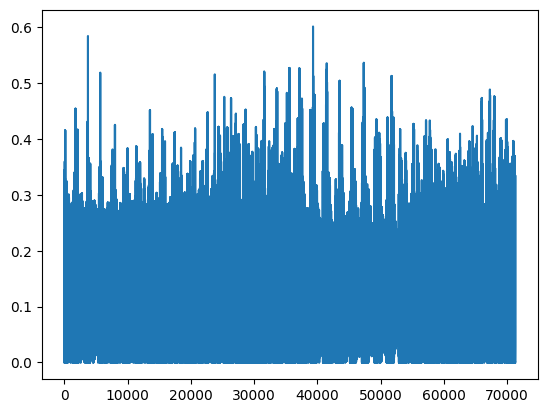

In [7]:
img = color.rgb2gray(data.chelsea())
fd = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),  cells_per_block=(2, 2))
plt.plot(fd)

## Questão 1

<p>
Utilize um classificador SVM com os dígitos manuscritos da base de dados MNIST. Para isso, extraia e gere o vetor de características HoG para cada uma das imagens. Este processo deve ser realizado tanto para o conjunto de treinamento quanto para o de teste. Registre cada um dos descritores em uma matriz. Usando os seguintes parâmetros no descritor <i>HoG (orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))</i>, será gerado um descritor de 144 elementos para uma imagem de 28x28 pixels.</p>

<p>
A função <i>feature_extraction(dataset)</i> será utilizada para extrair o descritor HoG das imagens. Lembre-se de redimensionar a imagem do formato unidimensional de 728 elementos para o formato bidimensional de 28x28 pixels antes de realizar a extração de características.
</p>

In [8]:
def feature_extraction(dataset):
  hog_features = []
  for image in dataset:
    # redimensionar a imagem para 28x28 pixels
    image_reshaped = image.reshape(28,28)
    # extrair as características HOG
    fd = feature.hog(image_reshaped, orientations=9, pixels_per_cell=(8, 8),  cells_per_block=(2, 2))
    hog_features.append(fd)
  return np.array(hog_features)

<p>Extraia descritores do conjunto de treinamento, validação e teste</p>

In [9]:
X_hog_train = feature_extraction(x_img_train)
X_hog_val = feature_extraction(x_img_val)
X_hog_test = feature_extraction(x_img_test)


# Processamentos dos dados
## Normalizar os dados

<p>O objetivo da normalização é alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças nos intervalos de valores.

* Normalização
$$X_{new} = \frac{ X - X_{min} }{ X_{max} - X_{min} }$$

* Padronização
$$X_{changed} = \frac{ X - \mu }{ \sigma } $$
</p>

<p>Normalizar os dados usando a normalização ppopr padronização.</p>

In [10]:
# padronização
std_scaler = preprocessing.StandardScaler()
Xn_hog_train = std_scaler.fit_transform(X_hog_train)
Xn_hog_val = std_scaler.transform(X_hog_val)
Xn_hog_test = std_scaler.transform(X_hog_test)

#### Instanciar m classificador SVM, logo treine e avalie o modelo com os conjuntos de validação e teste

In [11]:
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(Xn_hog_train, y_train)

pred_val = clf_svm.predict(Xn_hog_val)
pred_test = clf_svm.predict(Xn_hog_test)


### Matriz de confusão da validação

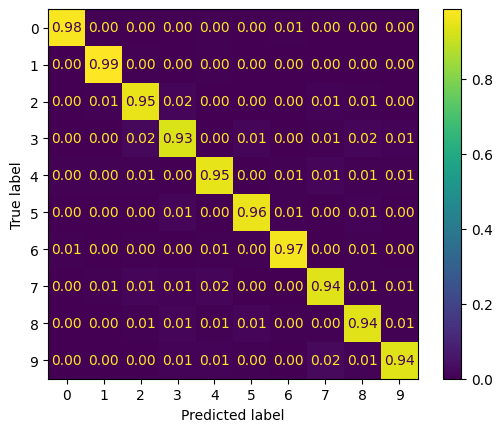

In [12]:
m = metrics.confusion_matrix(y_val, pred_val)
tot = np.sum(m, axis=1, keepdims=True)
np.set_printoptions(precision=2)
m_porc = m/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='.2f')
plt.show()

### Matriz de confusão do teste

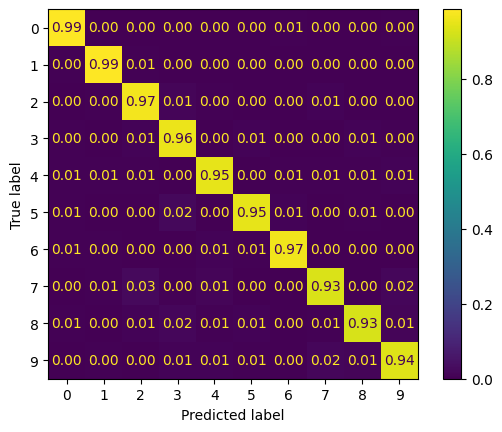

In [13]:
m = metrics.confusion_matrix(y_img_test, pred_test)
tot = np.sum(m, axis=1, keepdims=True)
np.set_printoptions(precision=2)
m_porc = m/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='.2f')
plt.show()


#### Calcular a acurácia, precision, recall e f1-score do conjunto de teste

In [38]:
print('Classifier metrics on test set')
print(f'Accurancy: {metrics.accuracy_score(y_img_test, pred_test)}%')
print(f"Precision: {metrics.precision_score(y_img_test, pred_test, average='weighted')}")
print(f"Recall: {metrics.recall_score(y_img_test, pred_test, average='weighted')}")
print(f"F1: {metrics.f1_score(y_img_test, pred_test, average='weighted')}")

Classifier metrics on test set
Accurancy: 0.9282%
Precision: 0.9279100783675948
Recall: 0.9282
F1: 0.927966259870734


## Descritor Daisy

<p>O descritor DAISY é um método para extração de características em imagens, desenvolvido especificamente para tarefas de correspondência e reconhecimento de imagens. Ele foi projetado para ser eficiente no cálculo e robusto a variações de iluminação e transformações geométricas, como rotação e escalonamento.</p>

<p>
O DAISY é inspirado no descritor SIFT, mas é mais eficiente computacionalmente, pois permite a extração de características densas sobre toda a imagem de forma rápida. Seu cálculo segue os seguintes passos:
<ol>
<li>Cálculo das Derivadas Gaussianas: São computadas as respostas das imagens a filtros gaussianos derivativos em diferentes orientações e escalas.</li>
<li>Amostragem Espacial Estruturada: Os pontos da imagem são organizados em um padrão concêntrico semelhante a uma margarida (daí o nome "DAISY").,</li>
<li>Acumulação de Gradientes: Para cada ponto da imagem, são calculadas histogramas de gradientes em regiões sobrepostas dispostas em anéis concêntricos.</li>
<li>Normalização: Para garantir robustez a variações de iluminação, os vetores extraídos são normalizados.</li>
</ol>

Vantagens do DAISY

<ul>
<li>Computação eficiente: Ideal para a extração densa em toda a imagem.</li>
<li>Robustez: Insensível a variações de iluminação, pequenas mudanças geométricas e ruído.</li>
<li>Aplicações: Usado em reconhecimento de objetos, emparelhamento de imagens, reconstrução 3D e mapeamento de profundidade.</li>
</ul>

O DAISY é uma escolha popular para tarefas que exigem descrições rápidas e densas, como reconstrução de superfícies e correspondência de imagens em larga escala.
</p>

<center>
<img src="https://scikit-image.org/docs/0.24.x/_images/sphx_glr_plot_daisy_001.png" alt="Drawing"  width="500">
</center>


### Questão 2

<p>Usando os seguintes parâmetros no descritor feature.daisy(img, step=180, radius=6, rings=2, histograms=6, orientations=8, visualize=True), será gerado um descritor de 104 elementos para uma imagem de $28 \times 28$ pixels.<p>

<p>Siga os mesmos passos realizados na Questao 1</p>

In [36]:
from skimage.feature import daisy
def feature_extraction2(dataset):
  daisy_features = []
  for image in dataset:
    # Redimensionar a imagem para 28x28 pixels
    image_reshaped = image.reshape(28, 28)
    # Extrair as características Daisy
    descs, descs_img = daisy(image_reshaped, step=180, radius=6, rings=2, histograms=6, orientations=8, visualize=True) # unpack the tuple
    daisy_features.append(descs.flatten())  # Aplainar o descritor Daisy
  return np.array(daisy_features)


#### Extração de características

In [37]:
X_daisy_train = feature_extraction2(x_img_train)
X_daisy_val = feature_extraction2(x_img_val)
X_daisy_test =  feature_extraction2(x_img_test)

#### Normalização

In [17]:
# padronização
std_scaler =  preprocessing.StandardScaler()
Xn_daisy_train =  std_scaler.fit_transform(X_daisy_train)
Xn_daisy_val =  std_scaler.transform(X_daisy_val)
Xn_daisy_test =  std_scaler.transform(X_daisy_test)

#### Instanciar o classificador, treinar e avaliar o modelo com os conjuntos de validaçao e teste

In [27]:
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(Xn_daisy_train, y_train)

pred_val_daisy = clf_svm.predict(Xn_daisy_val)
pred_test_daisy = clf_svm.predict(Xn_daisy_test)


#### Avaliar usando o conjunto de validação

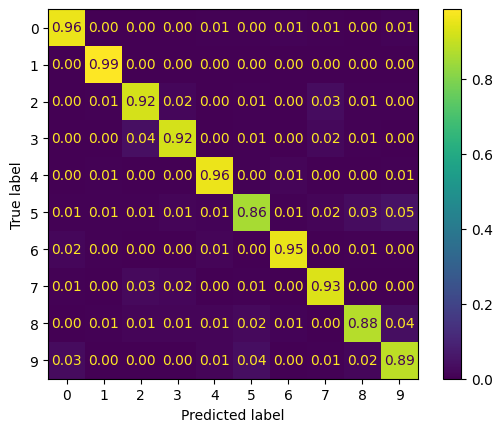

In [28]:
m = metrics.confusion_matrix(y_val, pred_val_daisy)
tot = np.sum(m, axis=1, keepdims=True)
np.set_printoptions(precision=2)
m_porc = m/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='.2f')
plt.show()

#### Avaliar usando o conjunto de teste

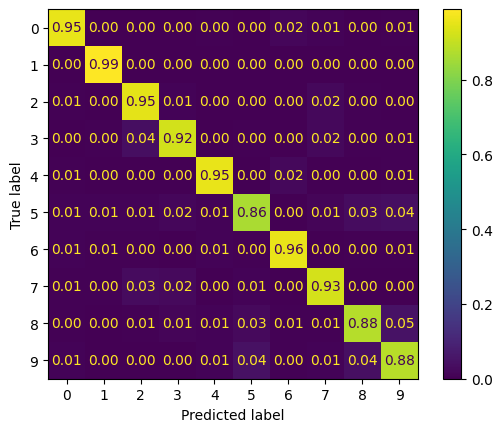

In [29]:
m = metrics.confusion_matrix(y_img_test, pred_test_daisy)
tot = np.sum(m, axis=1, keepdims=True)
np.set_printoptions(precision=2)
m_porc = m/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='.2f')
plt.show()

#### Calcular a acurácia, precision, recall e f1-score do conjunto de teste

In [43]:
print('Classifier metrics on test set')
print(f'Accurancy: {metrics.accuracy_score(y_img_test, pred_test_daisy)}%')
print(f"Precision: {metrics.precision_score(y_img_test, pred_test_daisy, average='weighted')}")
print(f"Recall: { metrics.recall_score(y_img_test, pred_test_daisy, average='weighted')}")
print(f"F1: { metrics.f1_score(y_img_test, pred_test_daisy, average='weighted')}")

Classifier metrics on test set
Accurancy: 0.9282%
Precision: 0.9279100783675948
Recall: 0.9282
F1: 0.927966259870734
